# 🌤️ Analysing the dataset at hand for sentiment 🌤️

Contents:
* Running topic modelling to check topics in articles
    * Taking extra list of stopwords from here: https://www.kaggle.com/datasets/rowhitswami/stopwords 
* Running Aspect-Based Sentiment Analysis (ABSA) on the articles for opinions on different topics


In [1]:
# Setting path
path_to_root = "/work/PernilleHøjlundBrams#8577/NLP_2023_P"

## Topic modelling - checking diversity of topics

In [3]:
'''
Preprocessing: This includes lower casing, removing stopwords and punctuation, and lemmatizing the words.

Dictionary and Corpus Creation: gensim requires a dictionary (word to id mapping) and a corpus (word frequency in documents) to perform LDA.

LDA Model Training: The LdaModel is trained on the corpus. Passes determine how many times the model iterates over the entire corpus.

View Topics: Each topic is represented as a mix of words with their corresponding weights indicating how important a word is for that topic.
'''

# ----------- Check diversity of topics -----------
# Set number of topics and custom stopwords that for some reason are not removed
num_topics = 10

import nltk
import numpy as np
from gensim import corpora, models
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
import pandas as pd

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

# And extra list of stopwords
sw_path = f'{path_to_root}/data/stopwords_eng.txt'

# Open and read the file into list
with open(sw_path, 'r', encoding='utf-8') as file:
    stopwords_extra = [line.strip() for line in file]

# Get data and collapse article body
df = pd.read_csv(f"{path_to_root}/data/articles.csv", sep = ",").drop(columns = ["Unnamed: 0"])
documents = df['Article Body']

# Preprocessing
stop = set(stopwords.words('english'))

# Update with extra list
stop.update(stopwords_extra)

# Add custom stopwords (iteratively being more aggressive with pruning)
custom_stopwords = ['say', 'says', 'said', 'also', 'one', 'two', 'three', 'mit','the','—'] 

# Update with custom stopwords
stop.update(custom_stopwords)

exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()

def clean(doc):
    stop_free = " ".join([word for word in doc.lower().split() if word not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc_clean = [clean(doc).split() for doc in documents]   

# Create a dictionary and corpus
dictionary = corpora.Dictionary(doc_clean)

# Explicitly filter out stopwords from the dictionary
stop_ids = [dictionary.token2id[stopword] for stopword in stop if stopword in dictionary.token2id]
dictionary.filter_tokens(bad_ids=stop_ids)
dictionary.compactify()  # remove gaps in id sequence after words that were removed

corpus = [dictionary.doc2bow(text) for text in doc_clean]

# LDA model
ldamodel = models.ldamodel.LdaModel(corpus, num_topics=num_topics, id2word = dictionary, passes=50)

# Results
topics = ldamodel.print_topics(num_topics=num_topics, num_words=3)
for topic in topics:
    print(topic)

[nltk_data] Downloading package stopwords to /home/ucloud/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ucloud/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


(0, '0.013*"ai" + 0.010*"science" + 0.010*"new"')
(1, '0.005*"brain" + 0.003*"image" + 0.003*"network"')
(2, '0.012*"research" + 0.011*"engineering" + 0.008*"science"')
(3, '0.013*"material" + 0.011*"model" + 0.009*"new"')
(4, '0.013*"data" + 0.012*"model" + 0.010*"network"')
(5, '0.006*"ai" + 0.005*"car" + 0.005*"vehicle"')
(6, '0.019*"model" + 0.014*"ai" + 0.012*"data"')
(7, '0.020*"robot" + 0.013*"image" + 0.011*"object"')
(8, '0.011*"student" + 0.008*"engineering" + 0.007*"team"')
(9, '0.011*"robot" + 0.009*"system" + 0.006*"new"')


   Topic_Num  Perc_Contribution  \
0          3             0.5708   
1          4             0.7646   
2          0             0.6168   
3          7             0.6204   
4          5             0.6126   
5          8             0.3037   
6          2             0.5273   
7          9             0.3435   
8          6             0.5991   
9          1             0.4018   

                                            Keywords  Num_Documents  \
0  material, model, new, researcher, protein, dat...             86   
1  data, model, network, system, researcher, neur...            213   
2  ai, science, new, computing, technology, resea...            226   
3  robot, image, object, human, researcher, model...            139   
4  ai, car, vehicle, road, technology, people, sy...             51   
5  student, engineering, team, professor, machine...            104   
6  research, engineering, science, system, profes...             74   
7  robot, system, new, research, lab, energy, 

/tmp/ipykernel_279517/2134123774.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Topic_Num', y='Num_Documents', data=df_dominant_topics, palette='hls')


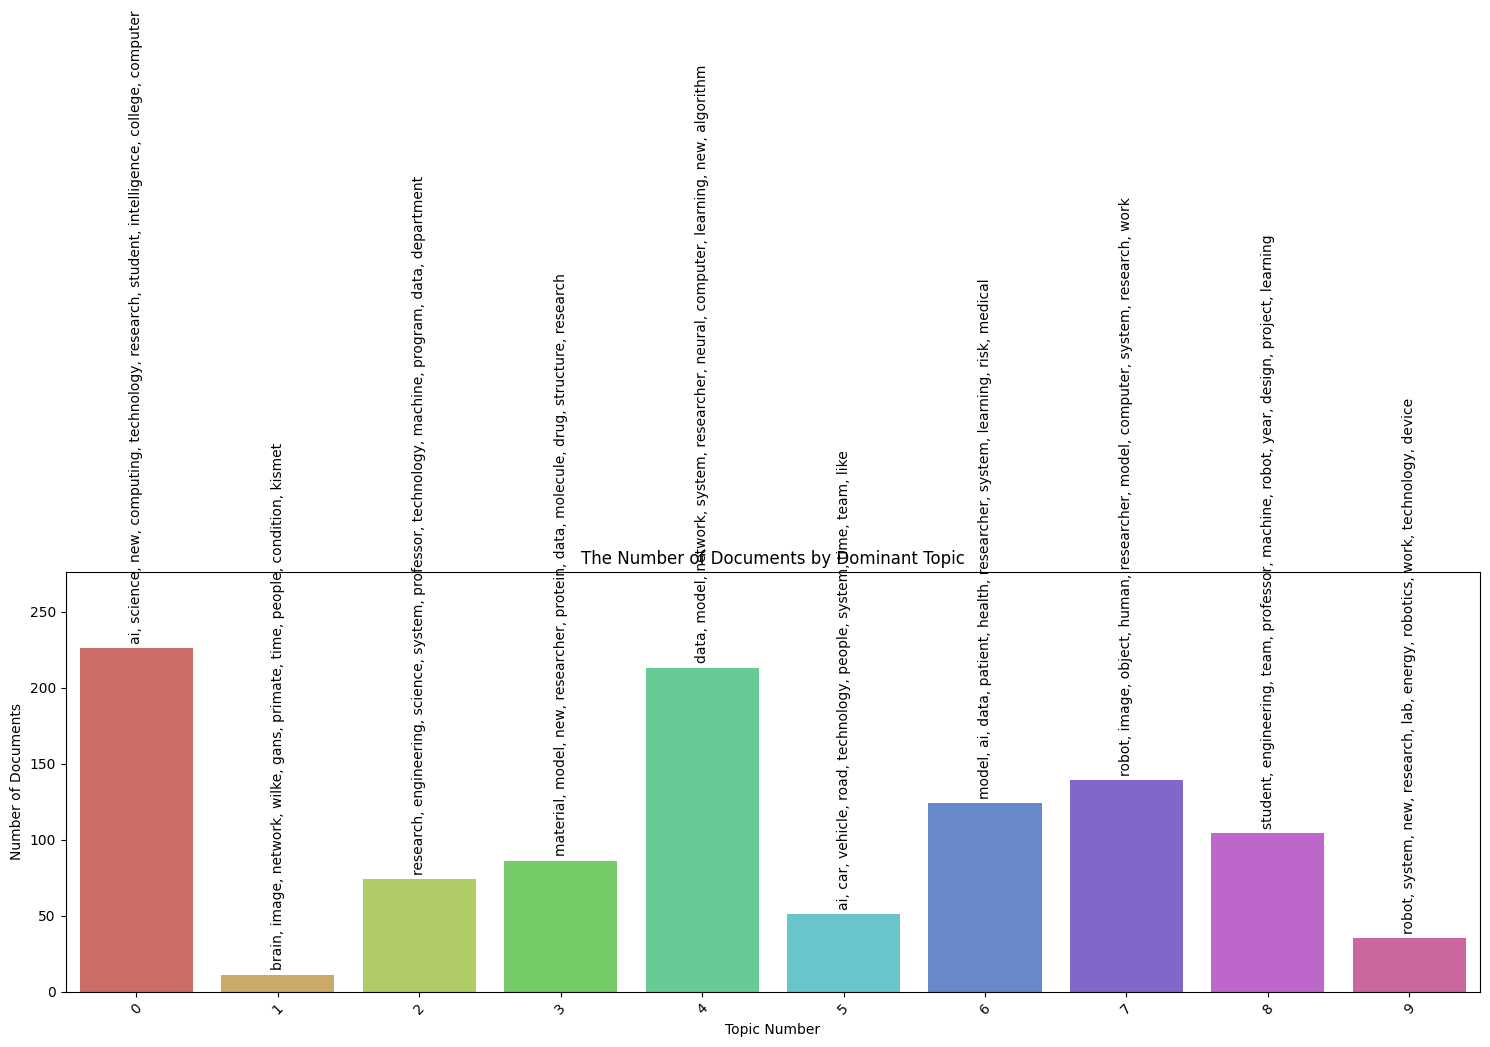

In [4]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have your LDA model (ldamodel) and corpus already prepared

# Function to get the dominant topic for each document
def format_topics_sentences(ldamodel, corpus):
    topic_data = []

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                topic_data.append([int(topic_num), round(prop_topic, 4), topic_keywords])
            else:
                break
    topics_df = pd.DataFrame(topic_data, columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])

    return topics_df

# Apply the function
df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, corpus=corpus)

# Count the number of documents for each topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Merge the counts and contributions with the original DataFrame
df_dominant_topics = df_topic_sents_keywords.drop_duplicates(subset=['Dominant_Topic'])
df_dominant_topics = df_dominant_topics.set_index('Dominant_Topic')
df_dominant_topics['Num_Documents'] = topic_counts
df_dominant_topics['Perc_Documents'] = topic_contribution

# Reset index
df_dominant_topics.reset_index(inplace=True)

# Change Column names
df_dominant_topics.columns = ['Topic_Num', 'Perc_Contribution', 'Keywords', 'Num_Documents', 'Perc_Documents']

# Show
print(df_dominant_topics)

# Reg Plot
# plt.figure(figsize=(10,6))
# sns.barplot(x='Topic_Num', y='Num_Documents', data=df_dominant_topics, palette='hls')
# plt.title('The Number of Documents by Dominant Topic')
# plt.xlabel('Topic Number')
# plt.ylabel('Number of Documents')
# plt.show()


#

# Plot with annotations
plt.figure(figsize=(15,10))  
ax = sns.barplot(x='Topic_Num', y='Num_Documents', data=df_dominant_topics, palette='hls')

# Add labels on top of the bars
for index, row in df_dominant_topics.iterrows():
    # Placing the topic keywords just above the bars:
    ax.text(row.Topic_Num, row.Num_Documents + 5, row.Keywords, color='black', ha="center", rotation=90)

plt.title('The Number of Documents by Dominant Topic')
plt.xlabel('Topic Number')
plt.ylabel('Number of Documents')
plt.ylim(0, df_dominant_topics['Num_Documents'].max() + 50)
plt.xticks(rotation=45) 
plt.tight_layout()  # Adjust the plot to ensure everything fits
plt.show()

In [5]:
# See dominant topics
for i in df_dominant_topics['Keywords']: 
    print(i)

material, model, new, researcher, protein, data, molecule, drug, structure, research
data, model, network, system, researcher, neural, computer, learning, new, algorithm
ai, science, new, computing, technology, research, student, intelligence, college, computer
robot, image, object, human, researcher, model, computer, system, research, work
ai, car, vehicle, road, technology, people, system, time, team, like
student, engineering, team, professor, machine, robot, year, design, project, learning
research, engineering, science, system, professor, technology, machine, program, data, department
robot, system, new, research, lab, energy, robotics, work, technology, device
model, ai, data, patient, health, researcher, system, learning, risk, medical
brain, image, network, wilke, gans, primate, time, people, condition, kismet
